In [1]:
# import the packages required
from numpy import asarray, expand_dims, ones, zeros
from numpy.random import randint, randn
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import load_model, Model
from keras.layers import (
    Concatenate,
    Conv2D,
    Conv2DTranspose,
    Dense,
    Dropout,
    Embedding,
    Flatten,
    Input,
    LeakyReLU,
    Reshape,
)
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def build_disc(in_shape: tuple = (28, 28, 1), n_classes: int = 10) -> Model:
    """
    Define the discriminator part of the GAN.
    """
    # label input
    in_label = Input(shape=(1,))
    # embedding for the categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to the image dimensions with linear activation
    li = Dense(in_shape[0] * in_shape[1])(li)
    # reshape to the additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat the label as a channel
    merge = Concatenate()([in_image, li])
    # downsample using convolution
    fe = LeakyReLU(alpha=0.2)(
        Conv2D(128, (3, 3), strides=(2, 2), padding="same")(merge)
        )
    # downsample using convolution
    fe = LeakyReLU(alpha=0.2)(
        Conv2D(128, (3, 3), strides=(2, 2), padding="same")(fe)
        )
    # flatten the feature maps and add a dropout layer to avoid overfitting
    fe = Dropout(0.4)(Flatten()(fe))
    # output layer with binary output
    out_layer = Dense(1, activation="sigmoid")(fe)

    # define model
    model = Model([in_image, in_label], out_layer)

    # compile the model
    model.compile(loss="binary_crossentropy",
                  optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=["accuracy"])
    return model


def build_gen(latent_dim: int = 100, n_classes: int = 10) -> Model:
    """
    Define the generator part of the GAN.
    """
    # label input
    in_label = Input(shape=(1,))
    # embedding for the categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    li = Dense(7 * 7)(li)
    # reshape to the additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for the 7x7 image
    gen = LeakyReLU(alpha=0.2)(Dense(128 * 7 * 7)(in_lat))
    gen = Reshape((7, 7, 128))(gen)
    # merge the image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14 using the transposed convolution layer
    gen = LeakyReLU(alpha=0.2)(
        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(merge)
        )
    # upsample to 28x28 using the transposed convolution layer
    gen = LeakyReLU(alpha=0.2)(
        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(gen)
        )
    # output layer
    out_layer = Conv2D(1, (7, 7), activation="tanh", padding="same")(gen)

    # define the model
    model = Model([in_lat, in_label], out_layer)
    return model


# define the combined generator and discriminator model, for updating the generator
def build_gan(gen: Model, disc: Model) -> Model:
    """
    Build the cGAN
    """
    # make the discriminator untrainable, i.e., freeze the weights
    disc.trainable = False
    # get the noise and label inputs from the generator model
    gen_noise, gen_label = gen.input
    # get the image output from the generator model
    gen_output = gen.output
    # connect the image output and label input from the generator as inputs to the discriminator
    gan_output = disc([gen_output, gen_label])

    # define the gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)

    # compile model
    model.compile(
        loss="binary_crossentropy", optimizer=Adam(lr=0.0002, beta_1=0.5)
        )
    return model


def load_fashionMNIST():
    """
    Load the images from the fashion MNIST dataset
    """
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3D by adding channels and convert the data type from int to float
    X = expand_dims(trainX, axis=-1).astype("float32")
    # normalize the values from [0, 255] to [-1, 1]
    X = (X - 127.5) / 127.5
    return [X, trainy]


def retrieve_samples(dataset, n_samples: int):
    """
    Retrieve samples from the input dataset.

    Their labels are 1 to signify that they belong to the original dataset.
    """
    # split the dataset into images and labels
    images, labels = dataset
    # choose random instances from the images and labels
    ix = randint(0, images.shape[0], n_samples)
    X, labels = images[ix], labels[ix]
    # generate the class labels - 1 to show that they belong to the original dataset
    y = ones((n_samples, 1))
    return [X, labels], y


def extract_random_points(latent_dim: int, n_samples: int, n_classes: int = 10):
    """
    Generate some fake points from the latent space.

    These points will act as input to the generator.

    Their labels are 0 to signify that they are artificially generated.
    """
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape them into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate the labels - 0 to show that they are artificially generated
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]


def generate_fake_instances(generator, latent_dim: int, n_samples: int):
    """
    Generate some fake samples from the latent dimension.
    """
    # generate some points in latent space
    z_input, labels_input = extract_random_points(latent_dim, n_samples)
    # predict the outputs
    images = generator.predict([z_input, labels_input])
    # create the class labels - 0 to show that they are artificially generated
    y = zeros((n_samples, 1))
    return [images, labels_input], y

In [3]:
def train(
    g_model,
    d_model,
    gan_model,
    dataset,
    latent_dim: int,
    n_epochs: int = 70,
    n_batch: int = 128,
):
    """
    Train the cGAN model.
    """
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            # get some randomly selected "real" samples
            [X_real, labels_real], y_real = retrieve_samples(
                dataset, half_batch)
            # update the discriminator model
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate some "fake" examples
            [X_fake, labels], y_fake = generate_fake_instances(
                g_model, latent_dim, half_batch
            )
            # update the discriminator model
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare some points in the latent space which will act as the input for the generator
            [z_input, labels_input] = extract_random_points(
                latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            # summarize loss on this batch
            print(
                ">Epoch = %d, %d/%d, d1=%.3f, d2=%.3f g=%.3f"
                % (i + 1, j + 1, bat_per_epo, d_loss1, d_loss2, g_loss)
            )
    # save the generator model
    g_model.save("./cgan_generator.h5")


def run_cgan_training():
    """
    Create the discriminator and generator and assemble them into the cGAN.

    Using the Fashion MNIST dataset, train the assembled cGAN model.
    """
    # create the discriminator and generator
    d_model = build_disc()
    # size of the latent space
    latent_dim = 100
    g_model = build_gen(latent_dim)
    # create the GAN
    gan_model = build_gan(g_model, d_model)
    # load the image data
    dataset = load_fashionMNIST()
    # train the model
    train(g_model, d_model, gan_model, dataset, latent_dim)


def save_plot(examples: np.ndarray, n: int):
    """
    Create and save a plot of generated images.
    """
    plt.figure(figsize=(35, 10))
    for i in range(n * n):
        # define the subplot
        plt.subplot(n, n, 1 + i)
        # turn off the axis in the plots
        plt.axis("off")
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap="gray_r")
    plt.show()


def clothing_generation():
    """
    Generate new pieces of clothing from the cGAN model developed before.
    """
    # load the model
    model = load_model("./cgan_generator.h5")
    # generate the images
    latent_points, _ = extract_random_points(100, 100)
    # specify the labels to specify the cloth type
    labels = asarray([x for _ in range(10) for x in range(10)])
    # generate the images of each type of cloth
    X  = model.predict([latent_points, labels])
    # scale from [-1, 1] to [0, 1]
    X = (X + 1) / 2.0
    # plot the result
    save_plot(X, 10)

In [4]:
run_cgan_training()

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 7ms/step
>Epoch = 65, 309/468, d1=0.660, d2=0.681 g=0.764
2/2 [==============================] - 0s 9ms/step
>Epoch = 65, 310/468, d1=0.664, d2=0.663 g=0.745
2/2 [==============================] - 0s 5ms/step
>Epoch = 65, 311/468, d1=0.696, d2=0.690 g=0.754
2/2 [==============================] - 0s 7ms/step
>Epoch = 65, 312/468, d1=0.692, d2=0.729 g=0.738
2/2 [==============================] - 0s 6ms/step
>Epoch = 65, 313/468, d1=0.687, d2=0.715 g=0.770
2/2 [==============================] - 0s 11ms/step
>Epoch = 65, 314/468, d1=0.683, d2=0.674 g=0.757
2/2 [==============================] - 0s 5ms/step
>Epoch = 65, 315/468, d1=0.689, d2=0.664 g=0.740
2/2 [==============================] - 0s 6ms/step
>Epoch = 65, 316/468, d1=0.678, d2=0.686 g=0.768
2/2 [==============================] - 0s 12ms/step
>Epoch = 65, 317/468, d1=0.720, d2=0.653 g=0.764
2/2 [==============================] - 0s 13ms/

>Epoch = 70, 468/468, d1=0.662, d2=0.704 g=0.785


4/4 [==============================] - 0s 49ms/step


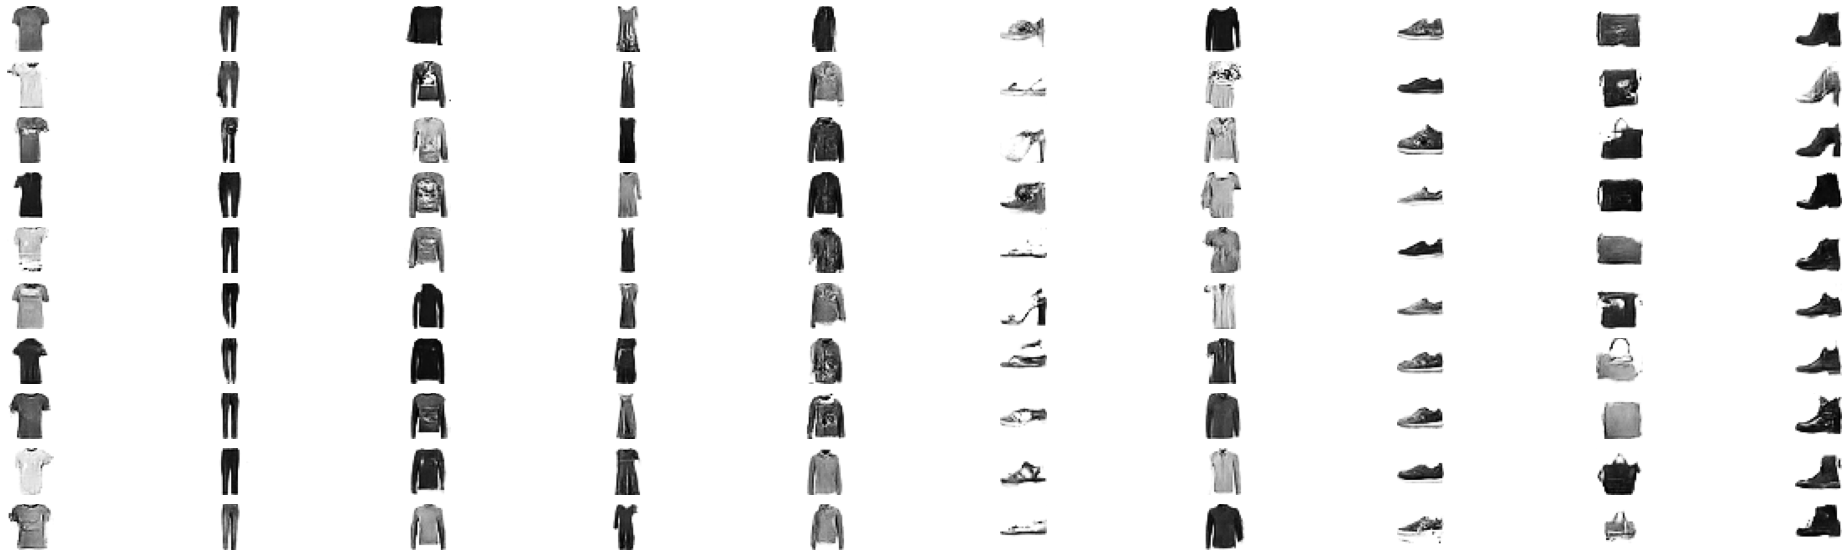

In [5]:
clothing_generation()